In [4]:
import numpy as np
import matplotlib.pyplot as plt

from astropy import units as u
from astropy.constants import c, M_sun, G

from scipy.integrate import solve_ivp
import pandas as pd


plt.rcParams.update({
    "text.usetex": True,                
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "figure.dpi": 200,                   
    "grid.alpha": 0.4,                    
})


# Strange Quark Matter

Equation of state:

$$
P(\epsilon)= \frac{1}{3}\epsilon - \frac{4B}{3}
$$


TOV:

$$
\begin{aligned}
\frac{d\bar p}{dr}&= -\frac{G M_0}{c^2}\frac{\bar \epsilon \bar M}{r^2}
\bigg(1+ \frac{\bar p}{\bar e}\bigg)
\bigg(1+ \frac{4\pi\epsilon_0}{M_0c^2}\frac{r^3\bar p}{\bar M}\bigg)
\bigg(1-\frac{2G M_0}{c^2}\frac{\bar M}{r}\bigg)^{-1}\\

\frac{d\bar M}{dr}&= \frac{4 \pi r^2 \bar \epsilon}{c^2}

\end{aligned}
$$


In [5]:
# Adimensionalization constants
# e_0 for mev/fm^3
# R_0 for km

#---- Saturation density and energy density ----

n_0 = 0.16 * u.fm**-3 # saturation density
m_0 = 939 * u.MeV / c**2  # neutron mass
e_0 = n_0 * m_0 * c**2 # saturation energy density

R_0 = (G * M_sun / c**2).to(u.km).value

print(f"Saturation energy density: {e_0:.3e}")

Saturation energy density: 1.502e+02 MeV / fm3


I will compare the results with those in: 


Modified MIT bag Models - part I: Thermodynamic consistency, stability windows and symmetry group.

Using PlotDigitiser to find the parameters of their EOS and Mass-Radius relation

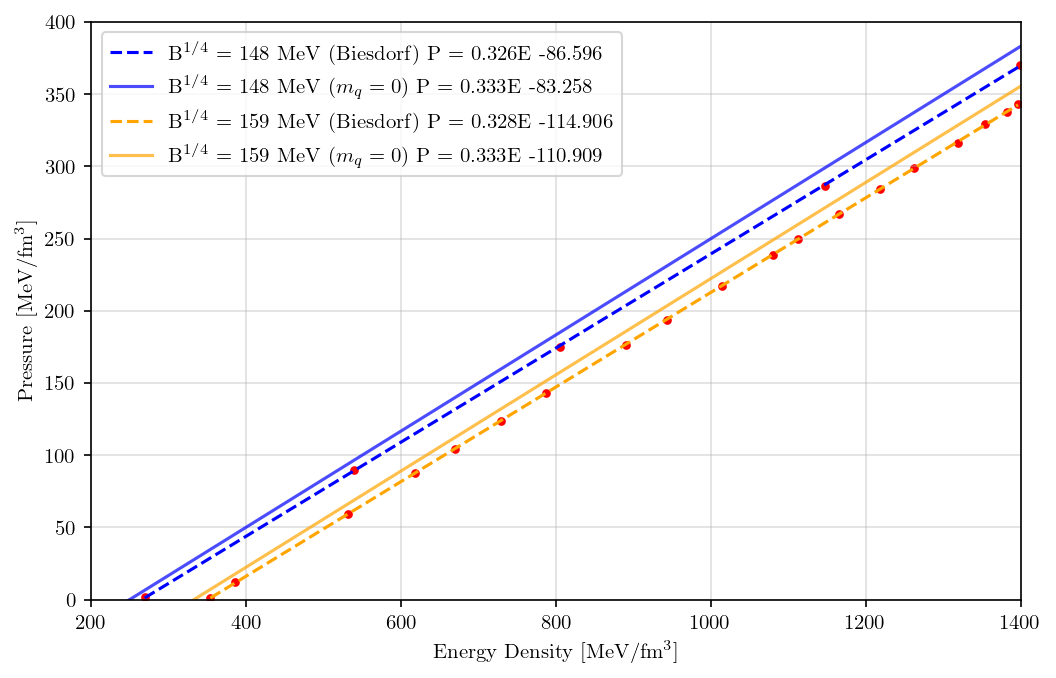

In [6]:

# ---- EOS -------
def P(e,B):
    return (e - 4 * B) / 3


#--------------------------------
#  MINIMUM BAG CONSTANT
#--------------------------------
B_1_4 = 148 * u.MeV  # Bag constant to the 1/4 power
hc = 197.327 * u.MeV * u.fm

B_dim = B_1_4 ** 4 / hc**3
Bmin = B_dim / e_0

#--------------------------------

plt.figure(figsize=(8,5), dpi=150)

# ---- Fit the data ----
data = pd.read_csv('../Data/eosBmin.csv')
plt.scatter(data['x'], data[' y'], color='red',s=10)
x = data['x'] / e_0
y = data[' y'] / e_0
b_min, m_min = np.polynomial.polynomial.polyfit(x, y, 1)


# ---- Plot the fit ----
plt.plot(x * e_0, m_min*x * e_0 + b_min * e_0,
         label='B$^{1/4}$ = 148 MeV (Biesdorf) 'f'P = {m_min:.3f}E {b_min*e_0.value:.3f}',
        color='blue', linestyle='--')

# ---- Plot my EOS ----

e = np.linspace(0 , 10, 1000)
p = P(e, Bmin)

plt.plot(e*e_0, p*e_0,
        label='B$^{1/4}$ = 148 MeV $(m_q=0)$ 'f' P = {0.333:.3f}E {P(0,Bmin)*e_0.value:.3f}', 
        linestyle='-', color='blue', alpha=0.7)




#--------------------------------
#  MAXIMUM BAG CONSTANT
#--------------------------------

B_1_4 = 159 * u.MeV  
hc = 197.327 * u.MeV * u.fm

B_dim = B_1_4 ** 4 / hc**3
Bmax = B_dim / e_0


# ---- Fit the data ----
data = pd.read_csv('../Data/eosBmax2.csv')
plt.scatter(data['x'], data[' y'],s=10, color='red')
x = data['x'] / e_0
y = data[' y'] / e_0
b_max, m_max = np.polynomial.polynomial.polyfit(x, y, 1)

# ---- Plot the fit ----
plt.plot(x * e_0, m_max*x * e_0 + b_max * e_0, 
        label='B$^{1/4}$ = 159 MeV (Biesdorf) 'f' P = {m_max:.3f}E {b_max*e_0.value:.3f}', 
        linestyle='--', color='orange')

# ---- Plot my EOS ----

e = np.linspace(0 , 10, 1000)
p = P(e, Bmax)

plt.plot(e*e_0, p*e_0, 
        label='B$^{1/4}$ = 159 MeV $(m_q=0)$' ''f' P = {0.333:.3f}E {P(0,Bmax)*e_0.value:.3f}',
        linestyle='-', color='orange', alpha=0.7)


plt.ylim(0, 400)
plt.xlim(200,1400)
plt.xlabel('Energy Density [MeV/fm$^3$]')
plt.ylabel('Pressure [MeV/fm$^3$]')
plt.legend()
plt.grid()

plt.savefig('EOS_strange_quark_matter.png', dpi=300)
plt.show()

# ---- NEW EOS -------

def fitted_P(e,m,b):
    return m*e + b

[<Quantity 2.77916656>, 5.642054302422223e-06]
Surface radius: 10.235563752946877
Pressure at surface: -1.1766531427490297e-16
Mass at surface: 1.9127351996169166
Final raw pressure: -1.1766531427490297e-16
Final pressure: -1.767803681666142e-14 MeV / fm3


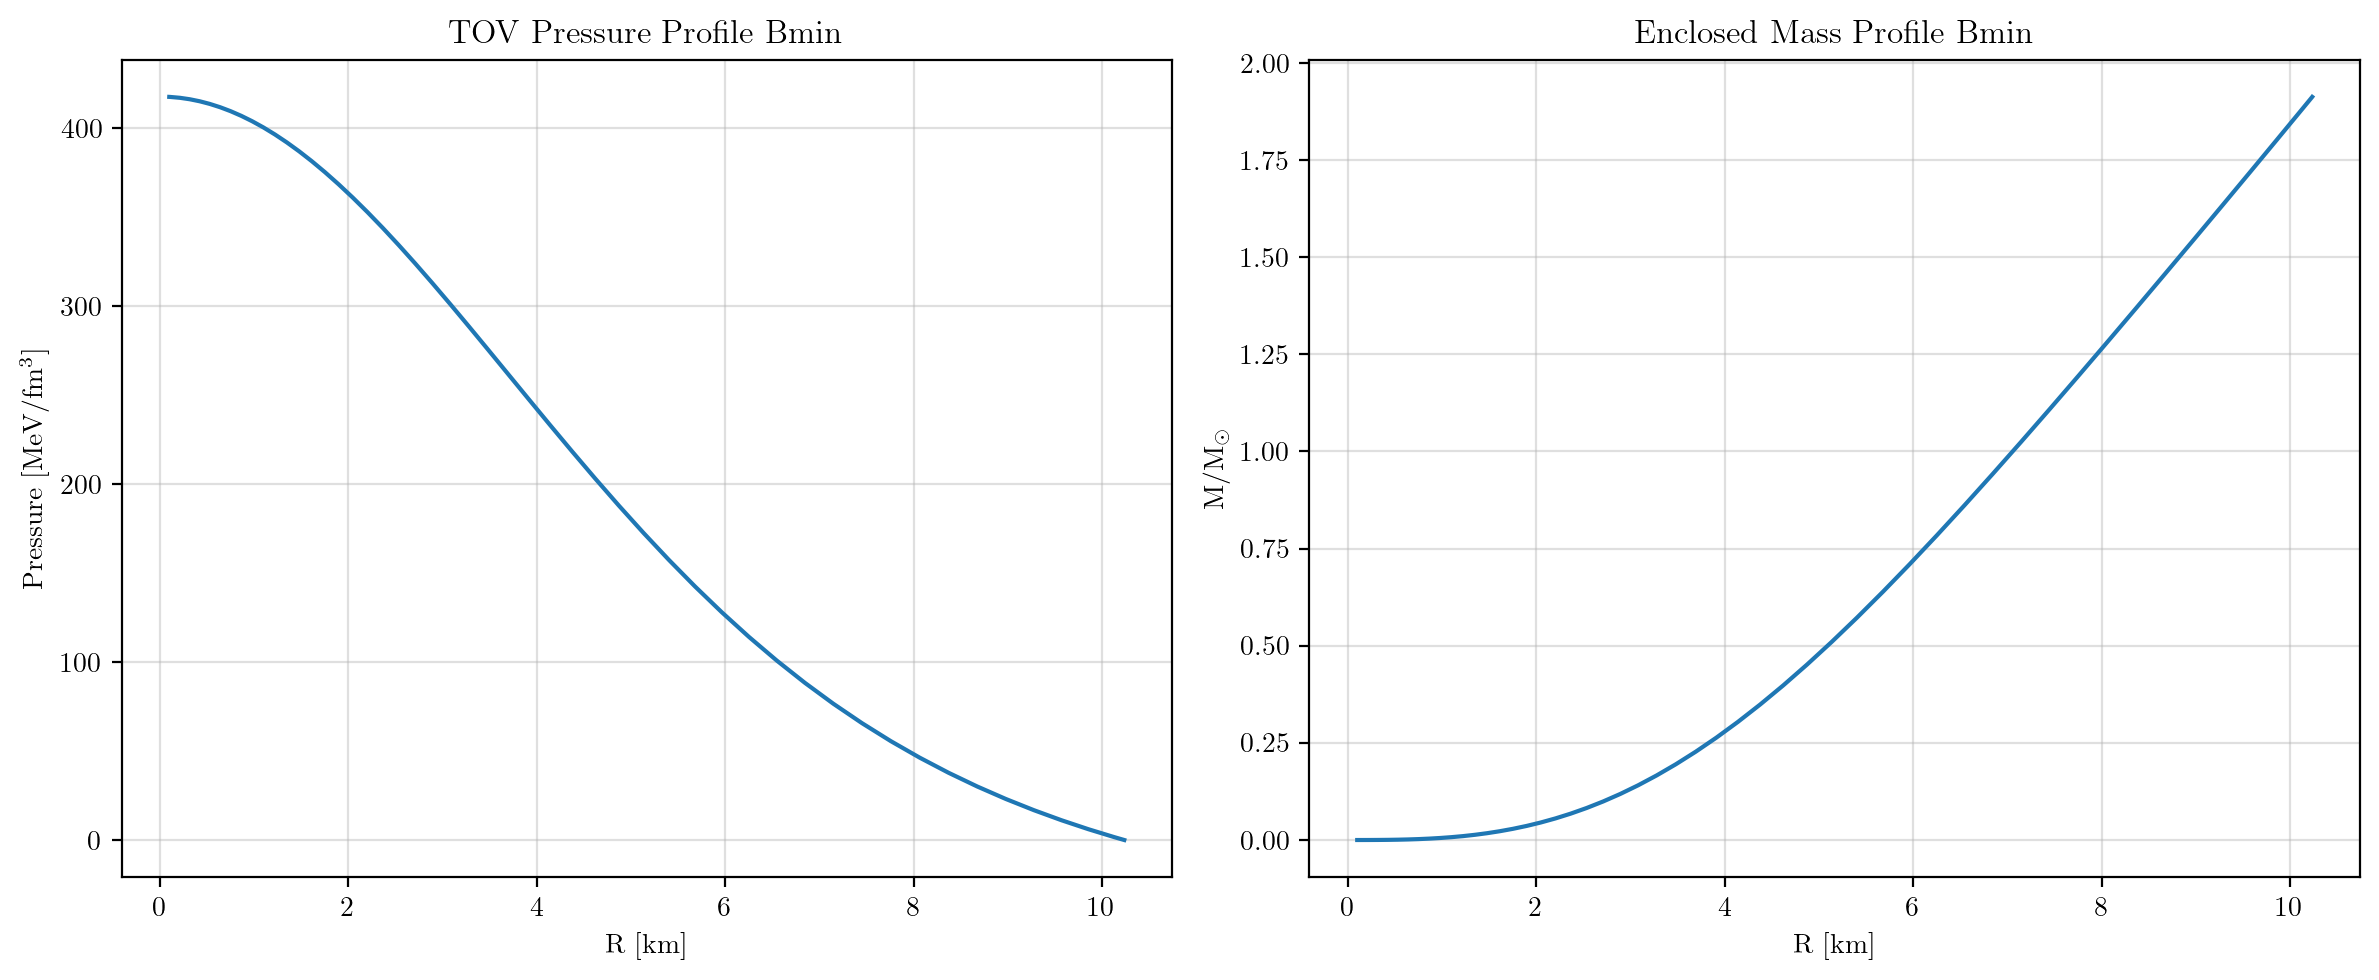

Star Radius (km): 10.235563752946877
Star Mass (M_sun): 1.9127351996169166


In [7]:
# ----------------------------------------------------
# TOV equations
# ----------------------------------------------------

alpha = (4 * np.pi * e_0 / c**2 / M_sun).to(1/u.km**3).value

def ode_TOV(r, x):
    p, M = x
    if p < 0:
        # avoid negative pressure during integration
        return [0, 0]

    e = 3 * p + 4 * Bmin  

    term1 = R_0 * e * M / r**2
    term2 = 1 + p / e
    if M == 0:
        term3 = 1.0
    else:
        term3 = 1.0 + alpha * r**3 * p / M
    term4 = 1 - 2 * R_0 * M / r

    if term4 <= 0:
        return [0, 0]

    dpdr = - term1 * term2 * term3 / term4
    dMdr = alpha * r**2 * e

    return [dpdr, dMdr]



# ----------------------------------------------------
# Initial conditions
# ----------------------------------------------------
central_energy = 10.0   # in units of e0
central_pressure = P(central_energy,Bmin)

r0 = 0.1             
central_mass_density = (central_energy * e_0 / c**2 /M_sun).to(1/ u.km**3)
central_mass = (4/3) * np.pi * r0**3 * central_mass_density.value
x0 = [central_pressure, central_mass]   # p(r0), M(r0)
print(x0)
# ----------------------------------------------------
# Event: stop integration when pressure goes to zero
# ----------------------------------------------------
def surface_event(r, x):
    return x[0]       # detects when between steps the pressure changes sign: pressure = 0, 
                      # the value given is not the pressure at that step, but an interpolation of where the pressure would be zero
surface_event.terminal = True # stop the integration
surface_event.direction = -1 # only detect zero-crossing from positive to negative

# ----------------------------------------------------
# Solve ODE
# ----------------------------------------------------
sol = solve_ivp(
    ode_TOV,
    (r0, 20),     # integrate up to r=20 (large enough)
    x0,
    events=surface_event, 
    max_step=0.5,
    rtol=1e-8, atol=1e-10 #tolerance of the step size selection
)

# Extract full profiles (for plotting etc.)
radius = sol.t
pressure = sol.y[0]
mass = sol.y[1]

# Surface location from event
R_surface = sol.t_events[0][0] # 0, 0 because only one event
P_surface = sol.y_events[0][0][0] #stores the state vector at the event
M_surface = sol.y_events[0][0][1]

print("Surface radius:", R_surface)
print("Pressure at surface:", P_surface)   # Should be exactly 0
print("Mass at surface:", M_surface)

# If you also want the last raw solver step (not recommended)
final_pressure_raw = sol.y[0, -1]
print("Final raw pressure:", final_pressure_raw)
radius = sol.t
pressure = sol.y[0]
mass = sol.y[1]
final_pressure = sol.y[0, -1] * e_0
print("Final pressure:", final_pressure)

# ----------------------------------------------------
# Plot results
# ----------------------------------------------------
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(radius, pressure*e_0)
plt.xlabel("R [km]")
plt.ylabel("Pressure [MeV/fm$^3$]")
plt.title("TOV Pressure Profile Bmin")
plt.grid()

plt.subplot(1,2,2)
plt.plot(radius, mass)
plt.xlabel("R [km]")
plt.ylabel("M/M$_\odot$")
plt.title("Enclosed Mass Profile Bmin")
plt.grid()

plt.tight_layout()
plt.show()

print("Star Radius (km):", R_surface)
print("Star Mass (M_sun):", M_surface)


No surface event for central energy = 1.7
No surface event for central energy = 1.842211055276382
No surface event for central energy = 1.9844221105527637
No surface event for central energy = 2.126633165829146


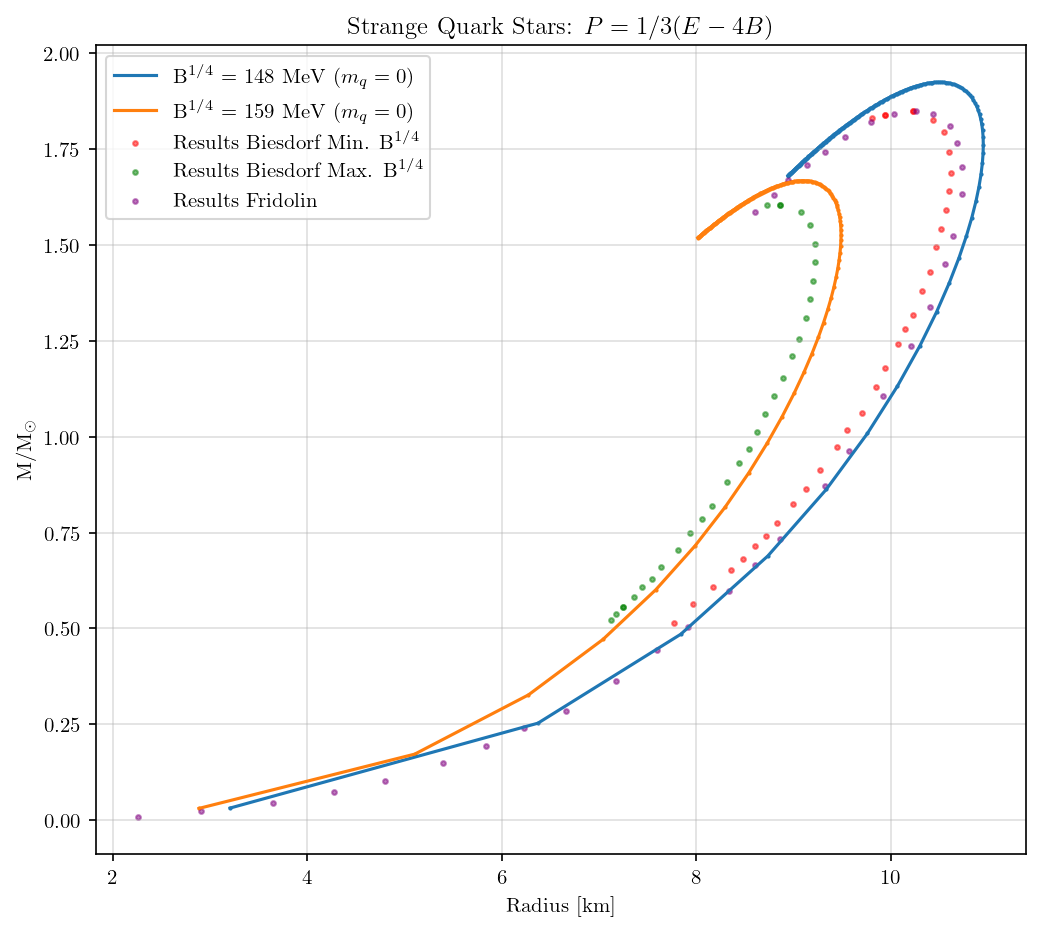

In [8]:

central_energies = np.linspace(1.7, 30.0, 200) 

def solve_TOV(central_energy,B):
    # ----------------------------------------------------
    # Initial conditions
    # ----------------------------------------------------

    central_pressure = P(central_energy,B)
    r0 = 0.1            
    central_mass_density = (central_energy * e_0 / c**2 /M_sun).to(1/ u.km**3)
    central_mass = (4/3) * np.pi * r0**3 * central_mass_density.value
    x0 = [central_pressure, central_mass]   # p(r0), M(r0)

    def ode_TOV(r, x):
        p, M = x
        if p < 0:
            # avoid negative pressure during integration
            return [0, 0]

        e = 3 * p + 4 * B 

        term1 = R_0 * e * M / r**2
        term2 = 1 + p / e
        if M == 0:
            term3 = 1.0
        else:
            term3 = 1.0 + alpha * r**3 * p / M
        term4 = 1 - 2 * R_0 * M / r

        if term4 <= 0:
            return [0, 0]

        dpdr = - term1 * term2 * term3 / term4
        dMdr = alpha * r**2 * e

        return [dpdr, dMdr]

    # ----------------------------------------------------
    # Solve ODE
    # ----------------------------------------------------

    # This solver automatically adjusts step size to control error
    sol = solve_ivp(
        ode_TOV,
        (r0, 100),     # integrate up to r=20 (large enough)
        x0,
        events=surface_event,
        max_step=0.1,
        rtol=1e-8, atol=1e-10 #tolerance error
    )

    if len(sol.t_events[0]) == 0:
        print(f"No surface event for central energy = {central_energy}")
        return np.nan, np.nan
    
    M_surface = sol.y_events[0][0][1]
    P_surface = sol.y_events[0][0][0]
    R_surface = sol.t_events[0][0]

    if P_surface > 1e-5 :
        print("Final pressure is far from 0:", P_surface* e_0, 'MeV/fm^3')

    return R_surface, M_surface

radii = []
masses = []
for ce in central_energies:
    R_star, M_star = solve_TOV(ce, Bmin)
    radii.append(R_star)
    masses.append(M_star)
plt.figure(figsize=(8,7), dpi=150)
plt.plot(radii, masses, label ='B$^{1/4}$ = 148 MeV $(m_q=0)$')
plt.scatter(radii, masses, s=1)


radii = []
masses = []
for ce in central_energies:
    R_star, M_star = solve_TOV(ce,Bmax)
    radii.append(R_star)
    masses.append(M_star)

plt.plot(radii, masses, label ='B$^{1/4}$ = 159 MeV $(m_q=0)$')
plt.scatter(radii, masses, s=1)


data = pd.read_csv('../Data/Bmin_biesdorf.csv')
plt.scatter(data['x'], data[' y'], label='Results  Biesdorf Min. B$^{1/4}$', color='red', s=5, alpha=0.5)

data = pd.read_csv('../Data/Bmax_biesdorf.csv')
plt.scatter(data['x'], data[' y'], label='Results  Biesdorf Max. B$^{1/4}$', color='green', s=5, alpha=0.5)

data = pd.read_csv('../Data/fridolinMR.csv')
plt.scatter(data['x'], data[' y'], label='Results Fridolin', color='purple', s=5, alpha=0.5)

plt.xlabel("Radius [km]")
plt.ylabel("M/M$_\odot$")
plt.title("Strange Quark Stars: $P = 1/3(E - 4B)$")
plt.grid()
plt.legend()
plt.savefig('Mass_Radius_strange_quark_matter.png', dpi=300)
plt.show()


In [9]:
B_fit_min_1_4 = (((- 3 /4 * b_min * e_0) * hc **3)**(1/4)).to(u.MeV)
B_fit_max_1_4 = (((- 3 /4 * b_max * e_0) * hc **3)**(1/4)).to(u.MeV)


print("B from fit min (MeV):", B_fit_min_1_4)
print("B from fit max (MeV):", B_fit_max_1_4)

B_fit_min = - 3 /4 * b_min
B_fit_max = - 3 /4 * b_max


B from fit min (MeV): 149.46174087626514 MeV
B from fit max (MeV): 160.41334918841355 MeV


In [10]:


def solve_TOV(central_energy,B):
    # ----------------------------------------------------
    # Initial conditions
    # ----------------------------------------------------

    central_pressure = P(central_energy,B)
    r0 = 0.1            
    central_mass_density = (central_energy * e_0 / c**2 /M_sun).to(1/ u.km**3)
    central_mass = (4/3) * np.pi * r0**3 * central_mass_density.value
    x0 = [central_pressure, central_mass]   # p(r0), M(r0)

    def ode_TOV(r, x):
        p, M = x
        if p < 0:
            # avoid negative pressure during integration
            return [0, 0]

        e = 3 * p + 4 * B 

        term1 = R_0 * e * M / r**2
        term2 = 1 + p / e
        if M == 0:
            term3 = 1.0
        else:
            term3 = 1.0 + alpha * r**3 * p / M
        term4 = 1 - 2 * R_0 * M / r

        if term4 <= 0:
            return [0, 0]

        dpdr = - term1 * term2 * term3 / term4
        dMdr = alpha * r**2 * e

        return [dpdr, dMdr]

    # ----------------------------------------------------
    # Solve ODE
    # ----------------------------------------------------

    # This solver automatically adjusts step size to control error
    sol = solve_ivp(
        ode_TOV,
        (r0, 100),     # integrate up to r=20 (large enough)
        x0,
        events=surface_event,
        max_step=0.1,
        rtol=1e-8, atol=1e-10 #tolerance error
    )

    if len(sol.t_events[0]) == 0:
        print(f"No surface event for central energy = {central_energy}")
        return np.nan, np.nan
    
    M_surface = sol.y_events[0][0][1]
    P_surface = sol.y_events[0][0][0]
    R_surface = sol.t_events[0][0]

    if P_surface > 1e-5 :
        print("Final pressure is far from 0:", P_surface* e_0, 'MeV/fm^3')

    return R_surface, M_surface

radii = []
masses = []
for ce in central_energies:
    R_star, M_star = solve_TOV(ce, B_fit_min)
    radii.append(R_star)
    masses.append(M_star)
plt.figure(figsize=(8,7), dpi=150)
plt.plot(radii, masses, label ='$B_{fit}^{1/4}$ = 149.46 MeV')
plt.scatter(radii, masses, s=1)


radii = []
masses = []
for ce in central_energies:
    R_star, M_star = solve_TOV(ce,B_fit_max)
    radii.append(R_star)
    masses.append(M_star)

plt.plot(radii, masses, label='$B_{fit}^{1/4}$ = 160.41 MeV')
plt.scatter(radii, masses, s=1)

data = pd.read_csv('../Data/Bmin_biesdorf.csv')
plt.scatter(data['x'], data[' y'], label='Results  Biesdorf Min. B$^{1/4}$', color='red', s=5, alpha=0.5)

data = pd.read_csv('../Data/Bmax_biesdorf.csv')
plt.scatter(data['x'], data[' y'], label='Results  Biesdorf Max. B$^{1/4}$', color='green', s=5, alpha=0.5)

data = pd.read_csv('../Data/fridolinMR.csv')
plt.scatter(data['x'], data[' y'], label='Results Fridolin', color='purple', s=5, alpha=0.5)


plt.xlabel("Radius [km]")
plt.ylabel("M/M$_\odot$")
plt.title("Strange Quark Stars: $P = 1/3(E - 4B_{fit})$")
plt.grid()
plt.legend()
plt.savefig('Mass_Radius_strange_quark_matter_intercept.png', dpi=300)
plt.show()

No surface event for central energy = 1.7
No surface event for central energy = 1.7
No surface event for central energy = 1.842211055276382
No surface event for central energy = 1.9844221105527637
No surface event for central energy = 2.126633165829146
No surface event for central energy = 2.2688442211055277


KeyboardInterrupt: 

No surface event for central energy = 1.7
No surface event for central energy = 1.7
No surface event for central energy = 1.842211055276382
No surface event for central energy = 1.9844221105527637
No surface event for central energy = 2.126633165829146
No surface event for central energy = 2.2688442211055277


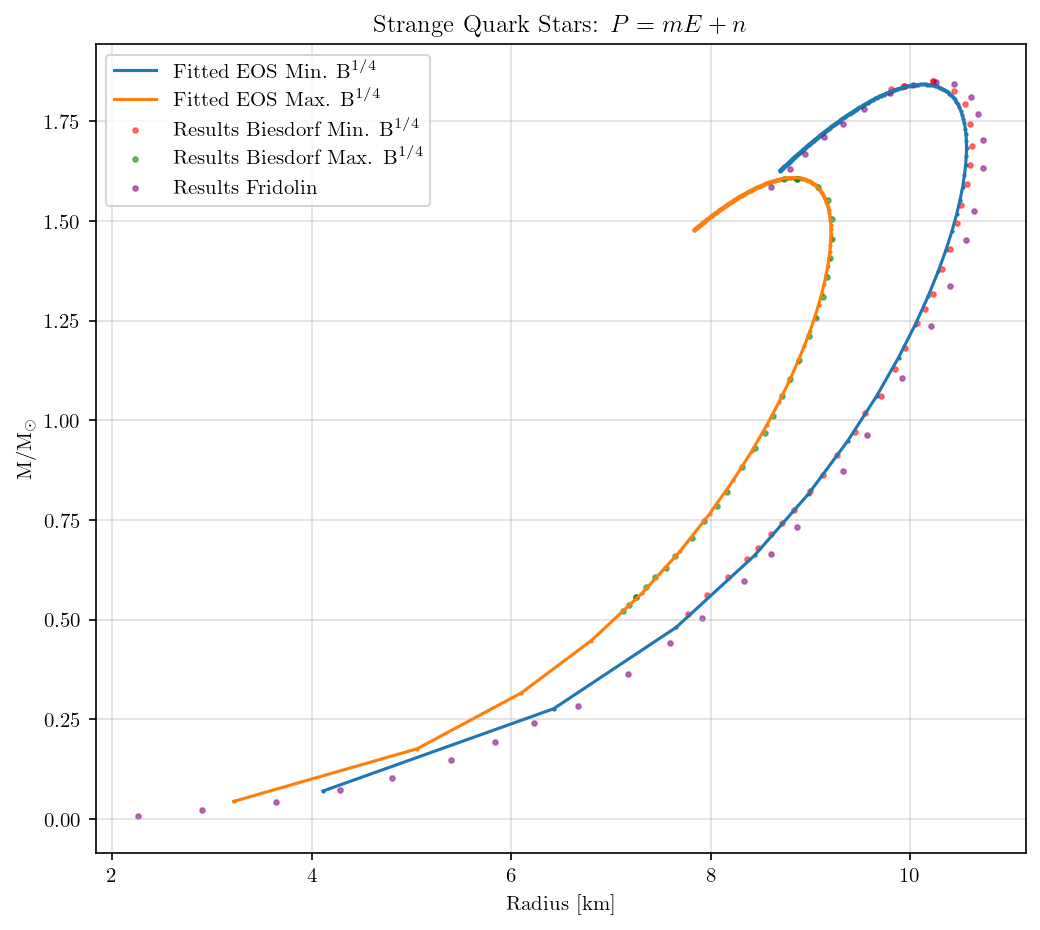

In [ ]:

def solve_TOV(central_energy, m, b):
    # ----------------------------------------------------
    # Initial conditions
    # ----------------------------------------------------

    central_pressure = fitted_P(central_energy, m, b)
    r0 = 0.1            
    central_mass_density = (central_energy * e_0 / c**2 /M_sun).to(1/ u.km**3)
    central_mass = (4/3) * np.pi * r0**3 * central_mass_density.value
    x0 = [central_pressure, central_mass]   # p(r0), M(r0)

    def ode_TOV(r, x):
        p, M = x
        if p < 0:
            # avoid negative pressure during integration
            return [0, 0]

        #e = 3 * p + 4 * B   # inverse of example EOS
        e = (p - b) / m
        # TOV terms
        term1 = R_0 * e * M / r**2
        term2 = 1 + p / e
        if M == 0:
            term3 = 1.0
        else:
            term3 = 1.0 + alpha * r**3 * p / M
        term4 = 1 - 2 * R_0 * M / r

        if term4 <= 0:
            return [0, 0]

        dpdr = - term1 * term2 * term3 / term4
        dMdr = alpha * r**2 * e

        return [dpdr, dMdr]

    # ----------------------------------------------------
    # Solve ODE
    # ----------------------------------------------------

    # This solver automatically adjusts step size to control error
    sol = solve_ivp(
        ode_TOV,
        (r0, 100),     # integrate up to r=20 (large enough)
        x0,
        events=surface_event,
        max_step=0.1,
        rtol=1e-8, atol=1e-10 #tolerance error
    )

    if len(sol.t_events[0]) == 0:
        print(f"No surface event for central energy = {central_energy}")
        return np.nan, np.nan
    
    M_surface = sol.y_events[0][0][1]
    P_surface = sol.y_events[0][0][0]
    R_surface = sol.t_events[0][0]

    if P_surface > 1e-5 :
        print("Final pressure is far from 0:", P_surface* e_0, 'MeV/fm^3')

    return R_surface, M_surface

radii = []
masses = []
for ce in central_energies:
    R_star, M_star = solve_TOV(ce, m_min, b_min)
    radii.append(R_star)
    masses.append(M_star)
plt.figure(figsize=(8,7), dpi=150)
plt.plot(radii, masses, label ='Fitted EOS Min. B$^{1/4}$')
plt.scatter(radii, masses, s=1)


radii = []
masses = []
for ce in central_energies:
    R_star, M_star = solve_TOV(ce, m_max, b_max)
    radii.append(R_star)
    masses.append(M_star)

plt.plot(radii, masses, label ='Fitted EOS Max. B$^{1/4}$')
plt.scatter(radii, masses, s=1)


data = pd.read_csv('../Data/Bmin_biesdorf.csv')
plt.scatter(data['x'], data[' y'], label='Results  Biesdorf Min. B$^{1/4}$', color='red', s=5, alpha=0.5)

data = pd.read_csv('../Data/Bmax_biesdorf.csv')
plt.scatter(data['x'], data[' y'], label='Results  Biesdorf Max. B$^{1/4}$', color='green', s=5, alpha=0.5)

data = pd.read_csv('../Data/fridolinMR.csv')
plt.scatter(data['x'], data[' y'], label='Results Fridolin', color='purple', s=5, alpha=0.5)


plt.xlabel("Radius [km]")
plt.ylabel("M/M$_\odot$")
plt.title("Strange Quark Stars: $P = m E + n$")
plt.grid()
plt.legend()
plt.savefig('Mass_Radius_strange_quark_matter_fitted_EOS.png', dpi=300)
plt.show()


In [ ]:
#estimation of chemical potential
m_s = 93 * u.MeV  # strange quark mass
diff = B_fit_min_1_4**4- (148 * u.MeV)**4
factor = 3 / 16 / np.pi**2 * m_s**2
chempotential_min = (diff/factor)**(1/2)

m_s = 93 * u.MeV  # strange quark mass
diff = B_fit_max_1_4**4- (159 * u.MeV)**4
chempotential_max = (diff/factor)**(1/2)
print("Chemical potential min (MeV):", chempotential_min)
print("Chemical potential max (MeV):", chempotential_max)

Chemical potential min (MeV): 342.1672210874457 MeV
Chemical potential max (MeV): 374.3776144131043 MeV


In [ ]:

chempotential_min = 350 * u.MeV  # quark chemical potential
chempotential_max = 350 * u.MeV  # quark chemical potential
factor = (3/(16*np.pi**2)*chempotential_min**2*m_s**2)/ (hc**3) / e_0

Beff_min = Bmin + factor
Beff_min_1_4= (Beff_min * e_0 * hc **3)**(1/4)



factor = (3/(16*np.pi**2)*chempotential_max**2*m_s**2)/ (hc**3) / e_0

Beff_max = Bmax +factor
Beff_max_1_4= (Beff_max * e_0 * hc **3)**(1/4)

print("Beff min (MeV):", Beff_min_1_4)
print("Beff max (MeV):", Beff_max_1_4)

Beff min (MeV): 149.52839909365213 MeV
Beff max (MeV): 160.2373312154384 MeV


No surface event for central energy = 1.7
No surface event for central energy = 1.7
No surface event for central energy = 1.842211055276382
No surface event for central energy = 1.9844221105527637
No surface event for central energy = 2.126633165829146
No surface event for central energy = 2.2688442211055277


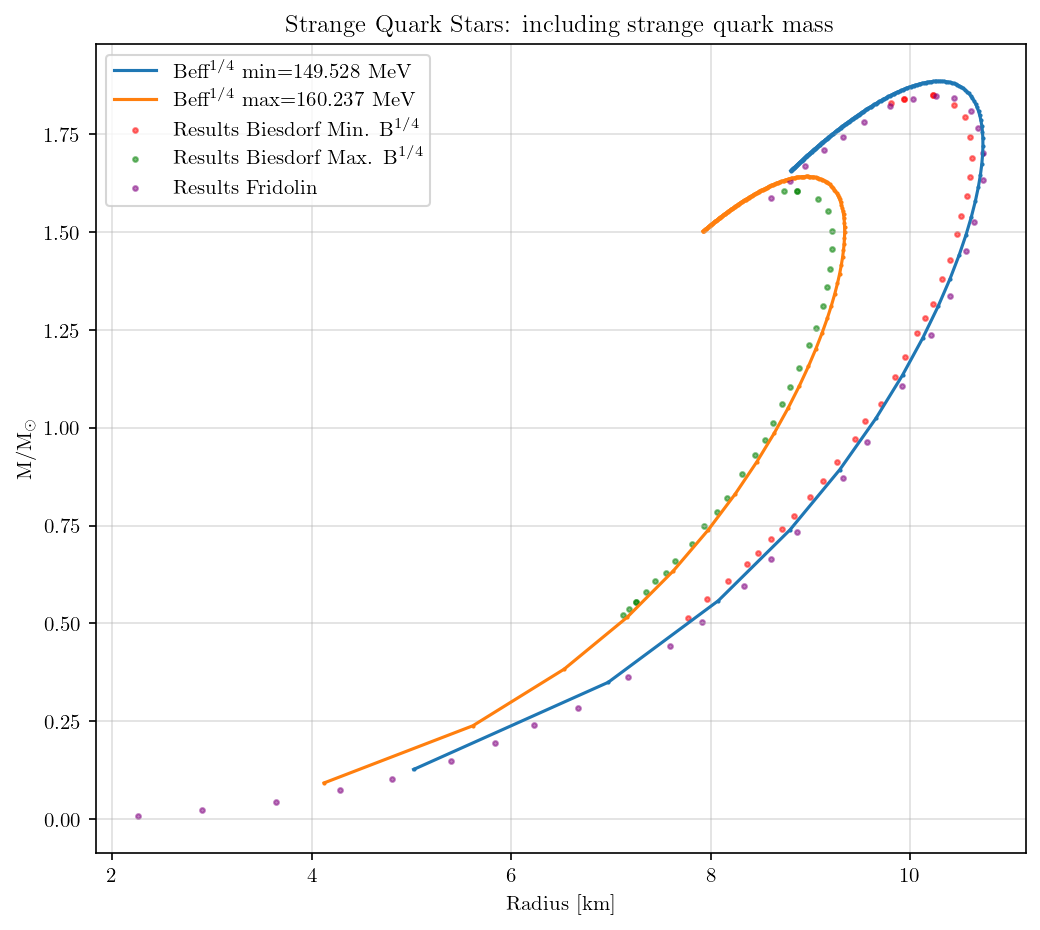

In [ ]:

def solve_TOV(central_energy, m, b):
    # ----------------------------------------------------
    # Initial conditions
    # ----------------------------------------------------
    central_pressure = fitted_P(central_energy, m, b)
    r0 = 0.1            
    central_mass_density = (central_energy * e_0 / c**2 /M_sun).to(1/ u.km**3)
    central_mass = (4/3) * np.pi * r0**3 * central_mass_density.value
    x0 = [central_pressure, central_mass]   # p(r0), M(r0)

    def ode_TOV(r, x):
        p, M = x
        if p < 0:
            # avoid negative pressure during integration
            return [0, 0]


        e = (p - b) / m
        # TOV terms
        term1 = R_0 * e * M / r**2
        term2 = 1 + p / e
        if M == 0:
            term3 = 1.0
        else:
            term3 = 1.0 + alpha * r**3 * p / M
        term4 = 1 - 2 * R_0 * M / r

        if term4 <= 0:
            return [0, 0]

        dpdr = - term1 * term2 * term3 / term4
        dMdr = alpha * r**2 * e

        return [dpdr, dMdr]

    # ----------------------------------------------------
    # Solve ODE
    # ----------------------------------------------------

    # This solver automatically adjusts step size to control error
    sol = solve_ivp(
        ode_TOV,
        (r0, 100),     # integrate up to r=20 (large enough)
        x0,
        events=surface_event,
        max_step=0.1,
        rtol=1e-8, atol=1e-10 #tolerance error
    )

    if len(sol.t_events[0]) == 0:
        print(f"No surface event for central energy = {central_energy}")
        return np.nan, np.nan
    
    M_surface = sol.y_events[0][0][1]
    P_surface = sol.y_events[0][0][0]
    R_surface = sol.t_events[0][0]

    if P_surface > 1e-5 :
        print("Final pressure is far from 0:", P_surface* e_0, 'MeV/fm^3')

    return R_surface, M_surface

radii = []
masses = []
m = 1/3
b = -4/3 * (Beff_min)
for ce in central_energies:
    R_star, M_star = solve_TOV(ce, m, b)
    radii.append(R_star)
    masses.append(M_star)
plt.figure(figsize=(8,7), dpi=150)
plt.plot(radii, masses, label ='Beff$^{1/4}$ min='f'{Beff_min_1_4:.3f}')
plt.scatter(radii, masses, s=1)


radii = []
masses = []
m = 1/3
b = -4/3 * (Beff_max)
for ce in central_energies:
    R_star, M_star = solve_TOV(ce, m, b)
    radii.append(R_star)
    masses.append(M_star)

plt.plot(radii, masses, label ='Beff$^{1/4}$ max='f'{Beff_max_1_4:.3f}')

plt.scatter(radii, masses, s=1)


data = pd.read_csv('../Data/Bmin_biesdorf.csv')
plt.scatter(data['x'], data[' y'], label='Results  Biesdorf Min. B$^{1/4}$', color='red', s=5, alpha=0.5)

data = pd.read_csv('../Data/Bmax_biesdorf.csv')
plt.scatter(data['x'], data[' y'], label='Results  Biesdorf Max. B$^{1/4}$', color='green', s=5, alpha=0.5)

data = pd.read_csv('../Data/fridolinMR.csv')
plt.scatter(data['x'], data[' y'], label='Results Fridolin', color='purple', s=5, alpha=0.5)


plt.xlabel("Radius [km]")
plt.ylabel("M/M$_\odot$")
plt.title("Strange Quark Stars: including strange quark mass")
plt.grid()
plt.legend()
plt.savefig('Mass_Radius_strange_quark_matter_including_strange_quark_mass.png', dpi=300)
plt.show()

In [ ]:
from scipy.optimize import fsolve

n0  = n_0.value

hc = 197.327 
B = 148 ** 4 / hc**3 # in MeV/fm^3

N_c_quarks = 3
N_c_lep = 1

m_s = 93  # strange quark mass
m_u = 0
m_d = 0
m_e = 0

In [ ]:


n0  = n_0.value

hc = 197.327 
B = 148 ** 4 / hc**3 # in MeV/fm^3

N_c_quarks = 3
N_c_lep = 1

m_s = 93  # strange quark mass
m_u = 0
m_d = 0
m_e = 0

In [ ]:

def number_density_massless(mu):
    # Per u, d (quarks): n = kF^3/pi^2, mu = kF
    if mu < 0: 
        return 0
    return (mu / hc)**3 / np.pi**2

def number_density_massive(mu, mass):
    # Per s (quark) n = kF^3/pi^2, mu = kF^2 + m^2
    if mu < mass:
        return 0.0
    kF = np.sqrt(mu**2 - mass**2)
    return (kF / hc)**3 / np.pi**2

def number_density_electron(mu):
    # Electrons: n = kF^3/(3*pi^2), mu = kF
    if mu < 0: 
        return 0 
    return (mu / hc)**3 / (3 * np.pi**2)


def pressure_f(N_c, mu_q, m_q):
    factor  = N_c * mu_q**4 / (24 * np.pi**2 * hc**3)
    z_q = m_q / mu_q
    if z_q >= 1: 
        return 0
    if z_q ==0:
        return factor
    term1 = (1-z_q**2)**(1/2)* (1-5/2 * z_q**2)
    term2 = 3/2 * z_q**4 * np.log( (1 + np.sqrt(1 - z_q**2)) / z_q )
    return factor * (term1 + term2) # MeV/fm^3

def energy_f(N_c, mu_q, m_q):
    factor  = N_c * mu_q**4 / (8 * np.pi**2 * hc**3)
    z_q = m_q / mu_q
    if z_q >= 1: 
        return 0
    if z_q ==0:
        return factor
    term1 = (1-z_q**2)**(1/2)* (1-1/2 * z_q**2)
    term2 = -1/2 * z_q**4 * np.log( (1 + np.sqrt(1 - z_q**2)) / z_q )
    return factor * (term1 + term2) # MeV/fm^3


# --- SISTEMA D'EQUACIONS A RESOLTRE ---

def equationsNB(vars, nB_target):
    mu_u, mu_e= vars
    
    # Beta equilibri
    mu_d = mu_u + mu_e
    mu_s = mu_d 
    
    # Densitats
    nu = number_density_massless(mu_u)
    nd = number_density_massless(mu_d)
    ns = number_density_massive(mu_s, m_s)
    ne = number_density_electron(mu_e)

    # 2/3 nu - 1/3 nd - 1/3 ns - ne = 0
    eq_charge = (2/3)*nu - (1/3)*nd - (1/3)*ns - ne

    # 1/3 (nu + nd + ns) = nB
    eq_baryon = (1/3)*(nu + nd + ns) - nB_target

    return [eq_charge, eq_baryon]


guess = [400, 5] # mu_u, mu_e en MeV 

nB = 5 * n0  

sol = fsolve(equationsNB, guess, args=(nB))
mu_u, mu_e = sol    
mu_d = mu_u + mu_e
mu_s = mu_d
    
nu = number_density_massless(mu_u)
nd = number_density_massless(mu_d)
ns = number_density_massive(mu_s, m_s)
ne = number_density_electron(mu_e)

check_nb = (1/3)*(nu + nd + ns)
check_charge = (2/3)*nu - (1/3)*nd - (1/3)*ns - ne

print(f"Check nB: {check_nb:.3f} fm^-3 (target: {nB:.3f} fm^-3)")
print(f"Check charge neutrality: {check_charge:.3e} fm^-3 (should be 0)")

print(f"nB: {nB:.3f} fm^-3, mu_u: {mu_u:.2f} MeV, mu_d: {mu_d:.2f} MeV, mu_s: {mu_s:.2f} MeV, mu_e: {mu_e:.2f} MeV")

pressure_total = (pressure_f(6, mu_u, m_u) + pressure_f(6, mu_d, m_d) +
                  pressure_f(6, mu_s, m_s) + pressure_f(2, mu_e, m_e)) - B

print(f"Pressure at nB={nB/n0:.2f} n0: {pressure_total:.2f} MeV/fm^3")

energy_total =  (energy_f(6, mu_u, m_u) + energy_f(6, mu_d, m_d) +
                 energy_f(6, mu_s, m_s) + energy_f(2, mu_e, m_e)) + B

print(f"Energy at nB={nB/n0:.2f} n0: {energy_total:.2f} MeV/fm^3")


p = (pressure_total / e_0).value

z_s = m_s / mu_s # adimensional

e = 3 * pressure_total + 4 * B + 6/(4* np.pi**2) * mu_s**4/hc**3 * z_s**(2)* ((1-z_s**2)**0.5 - z_s**2 * np.log((1 + (1 - z_s**2)**0.5)/z_s))
print(f"Energy density at nB={nB/n0:.2f} n0: {e:.2f} MeV/fm^3")


check_e = energy_total - e
if abs(check_e) > 1e-6:
        print(f"Warning: energy density check failed: {check_e:.3e} MeV/fm^3")
        print('for nB=', nB)
        

Check nB: 0.800 fm^-3 (target: 0.800 fm^-3)
Check charge neutrality: 7.400e-13 fm^-3 (should be 0)
nB: 0.800 fm^-3, mu_u: 392.93 MeV, mu_d: 398.36 MeV, mu_s: 398.36 MeV, mu_e: 5.43 MeV
Pressure at nB=5.00 n0: 169.68 MeV/fm^3
Energy at nB=5.00 n0: 782.04 MeV/fm^3
Energy density at nB=5.00 n0: 782.04 MeV/fm^3


In [ ]:
#now for all massive quarks

m_u = 4
m_d = 4
m_s = 93

n0  = n_0.value
# --- SISTEMA D'EQUACIONS A RESOLTRE ---

def equationsNB2(vars, nB_target):
    mu_u, mu_e= vars
    
    # Beta equilibri
    mu_d = mu_u + mu_e
    mu_s = mu_d 
    
    # Densitats
    nu = number_density_massive(mu_u, m_u)
    nd = number_density_massive(mu_d, m_d)
    ns = number_density_massive(mu_s, m_s)
    ne = number_density_electron(mu_e)

    # 2/3 nu - 1/3 nd - 1/3 ns - ne = 0
    eq_charge = (2/3)*nu - (1/3)*nd - (1/3)*ns - ne

    # 1/3 (nu + nd + ns) = nB
    eq_baryon = (1/3)*(nu + nd + ns) - nB_target

    return [eq_charge, eq_baryon]


guess = [400, 5] # mu_u, mu_e en MeV 

nB = 5 * n0  

sol = fsolve(equationsNB2, guess, args=(nB))
mu_u, mu_e = sol    
mu_d = mu_u + mu_e
mu_s = mu_d
    
nu = number_density_massive(mu_u, m_u)
nd = number_density_massive(mu_d, m_d)
ns = number_density_massive(mu_s, m_s)
ne = number_density_electron(mu_e)

check_nb = (1/3)*(nu + nd + ns)
check_charge = (2/3)*nu - (1/3)*nd - (1/3)*ns - ne

print(f"Check nB: {check_nb:.3f} fm^-3 (target: {nB:.3f} fm^-3)")
print(f"Check charge neutrality: {check_charge:.3e} fm^-3 (should be 0)")

print(f"nB: {nB:.3f} fm^-3, mu_u: {mu_u:.2f} MeV, mu_d: {mu_d:.2f} MeV, mu_s: {mu_s:.2f} MeV, mu_e: {mu_e:.2f} MeV")

pressure_total = (pressure_f(6, mu_u, m_u) + pressure_f(6, mu_d, m_d) +
                  pressure_f(6, mu_s, m_s) + pressure_f(2, mu_e, m_e)) - B

print(f"Pressure at nB={nB/n0:.2f} n0: {pressure_total:.2f} MeV/fm^3")

energy_total =  (energy_f(6, mu_u, m_u) + energy_f(6, mu_d, m_d) +
                 energy_f(6, mu_s, m_s) + energy_f(2, mu_e, m_e)) + B

print(f"Energy at nB={nB/n0:.2f} n0: {energy_total:.2f} MeV/fm^3")


p = (pressure_total / e_0).value

z_s = m_s / mu_s # adimensional

e = 3 * pressure_total + 4 * B + 6/(4* np.pi**2) * mu_s**4/hc**3 * z_s**(2)* ((1-z_s**2)**0.5 - z_s**2 * np.log((1 + (1 - z_s**2)**0.5)/z_s))
print(f"Energy density at nB={nB/n0:.2f} n0: {e:.2f} MeV/fm^3")


check_e = energy_total - e
if abs(check_e) > 1e-6:
        print(f"Warning: energy density check failed: {check_e:.3e} MeV/fm^3")
        print('for nB=', nB)
        

Check nB: 0.800 fm^-3 (target: 0.800 fm^-3)
Check charge neutrality: 7.257e-13 fm^-3 (should be 0)
nB: 0.800 fm^-3, mu_u: 392.95 MeV, mu_d: 398.37 MeV, mu_s: 398.37 MeV, mu_e: 5.42 MeV
Pressure at nB=5.00 n0: 169.66 MeV/fm^3
Energy at nB=5.00 n0: 782.09 MeV/fm^3
Energy density at nB=5.00 n0: 781.99 MeV/fm^3
for nB= 0.8


energies dont match because the formula is not corrected

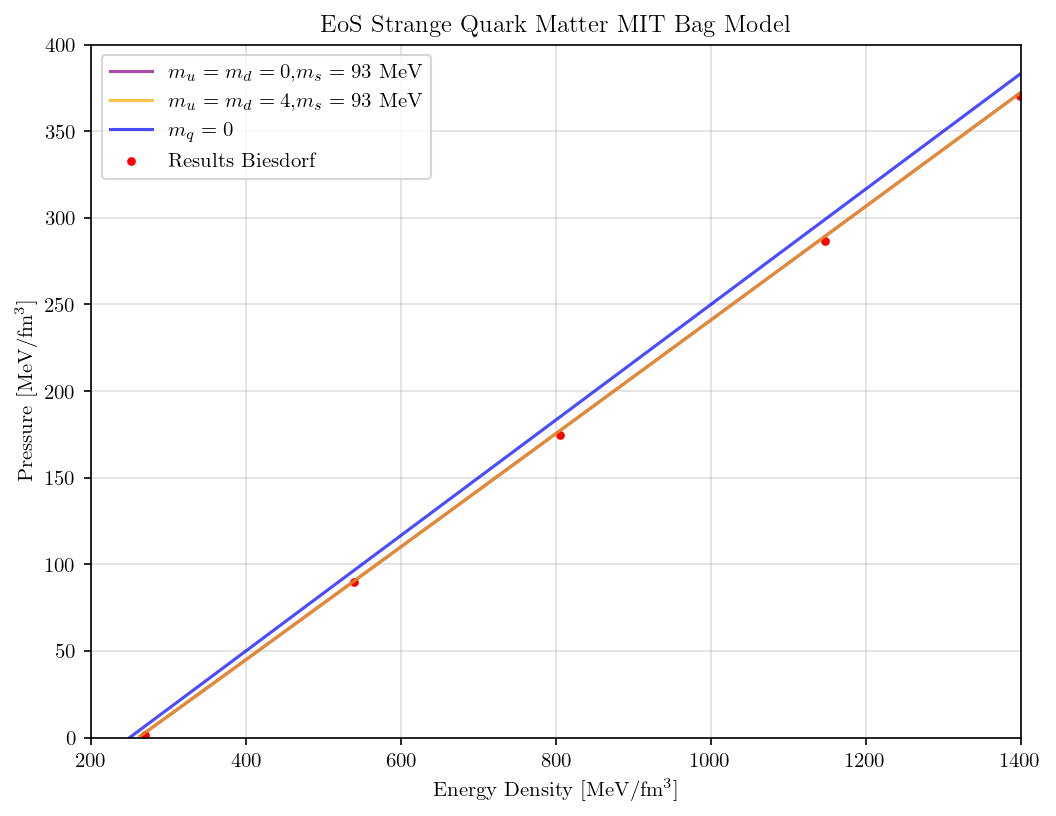

Number of points in EOS with positive pressure: 9964
Failed points (negative pressure): 36
Number of points in EOS with positive pressure: 9964
Failed points (negative pressure): 36


In [ ]:
n0  = n_0.value

hc = 197.327 
B = 148 ** 4 / hc**3 # in MeV/fm^3

N_c_quarks = 3
N_c_lep = 1

m_s = 93  # strange quark mass
m_u = 0
m_d = 0
m_e = 0

list_nb = np.linspace(0.1, 500, 10000) * n0
list_failed_nb = []
list_e = []
list_p = []
for nB in list_nb:
    sol = fsolve(equationsNB, guess, args=(nB))
    mu_u, mu_e = sol    
    mu_d = mu_u + mu_e
    mu_s = mu_d
        
    nu = number_density_massless(mu_u)
    nd = number_density_massless(mu_d)
    ns = number_density_massive(mu_s, m_s)
    ne = number_density_electron(mu_e)

    check_nb = (1/3)*(nu + nd + ns) - nB
    check_charge = (2/3)*nu - (1/3)*nd - (1/3)*ns - ne

    if abs(check_nb) > 1e-6:
        print(f"Warning: nB check failed: {check_nb:.3e} fm^-3")

    if abs(check_charge) > 1e-6:
        print(f"Warning: charge neutrality check failed: {check_charge:.3e} fm^-3")


    pressure_total = (pressure_f(6, mu_u, m_u) + pressure_f(6, mu_d, m_d) +
                    pressure_f(6, mu_s, m_s) + pressure_f(2, mu_e, m_e)) - B
    
    if pressure_total < 0:
        #print('Negative pressure reached, stopping at nB=', nB)
        list_failed_nb.append(nB)
        continue


    energy_total =  (energy_f(6, mu_u, m_u) + energy_f(6, mu_d, m_d) +
                    energy_f(6, mu_s, m_s) + energy_f(2, mu_e, m_e)) + B

    z_s = m_s / mu_s 

    e = 3 * pressure_total + 4 * B + 6/(4* np.pi**2) * mu_s**4/hc**3 * z_s**(2)* ((1-z_s**2)**0.5 - z_s**2 * np.log((1 + (1 - z_s**2)**0.5)/z_s))
    check_e = energy_total - e
    
    if abs(check_e) > 1e-6:
        print(f"Warning: energy density check failed: {check_e:.3e} MeV/fm^3")
        print('for nB=', nB)

    list_e.append(e)
    list_p.append(pressure_total)



plt.figure(figsize=(8,6), dpi=150)
#plt.scatter(np.array(list_e), np.array(list_p), color='purple',marker='x', alpha=0.4)
plt.plot(list_e, list_p, 
        label='$m_u = m_d = 0$,$m_s = 93$ MeV', color='purple', alpha=0.7)
plt.xlabel('Energy Density [MeV/fm$^3$]')
plt.ylabel('Pressure [MeV/fm$^3$]')
plt.grid()
plt.legend()




#-------------------------
m_s = 93  # strange quark mass
m_u = 4
m_d = 4
m_e = 0

list_nb2 = np.linspace(0.1, 500, 10000) * n0
list_failed_nb2 = []
list_e2 = []
list_p2 = []
for nB in list_nb2:
    sol = fsolve(equationsNB2, guess, args=(nB))
    mu_u, mu_e = sol    
    mu_d = mu_u + mu_e
    mu_s = mu_d
        
    nu = number_density_massive(mu_u, m_u)
    nd = number_density_massive(mu_d, m_d)
    ns = number_density_massive(mu_s, m_s)
    ne = number_density_electron(mu_e)

    check_nb = (1/3)*(nu + nd + ns) - nB
    check_charge = (2/3)*nu - (1/3)*nd - (1/3)*ns - ne

    if abs(check_nb) > 1e-6:
        print(f"Warning: nB check failed: {check_nb:.3e} fm^-3")

    if abs(check_charge) > 1e-6:
        print(f"Warning: charge neutrality check failed: {check_charge:.3e} fm^-3")


    pressure_total = (pressure_f(6, mu_u, m_u) + pressure_f(6, mu_d, m_d) +
                    pressure_f(6, mu_s, m_s) + pressure_f(2, mu_e, m_e)) - B
    
    if pressure_total < 0:
        #print('Negative pressure reached, stopping at nB=', nB)
        list_failed_nb2.append(nB)
        continue


    energy_total =  (energy_f(6, mu_u, m_u) + energy_f(6, mu_d, m_d) +
                    energy_f(6, mu_s, m_s) + energy_f(2, mu_e, m_e)) + B

    z_s = m_s / mu_s 


    list_e2.append(energy_total)
    list_p2.append(pressure_total)



plt.plot(list_e2, list_p2, 
        label='$m_u = m_d = 4$,$m_s = 93$ MeV', color='orange', alpha=0.7)
plt.xlabel('Energy Density [MeV/fm$^3$]')
plt.ylabel('Pressure [MeV/fm$^3$]')
plt.title('EoS Strange Quark Matter MIT Bag Model')
plt.grid()
plt.legend()



# ---- EOS -------
def P(e,B):
    return (e - 4 * B) / 3


#--------------------------------
#  MINIMUM BAG CONSTANT
#--------------------------------
B_1_4 = 148 * u.MeV  # Bag constant to the 1/4 power
hc = 197.327 * u.MeV * u.fm

B_dim = B_1_4 ** 4 / hc**3
Bmin = B_dim / e_0

#--------------------------------


# ---- Plot my EOS ----

e = np.linspace(0 , 10, 1000)
p = P(e, Bmin)

plt.plot(e*e_0, p*e_0,
        label='$m_q=0$', 
        linestyle='-', color='blue', alpha=0.7)


# ---- Fit the data ----
data = pd.read_csv('../Data/eosBmin.csv')
plt.scatter(data['x'], data[' y'], color='red',s=10, label='Results Biesdorf')
x = data['x'] / e_0
y = data[' y'] / e_0



#--------------------------------
#  MAXIMUM BAG CONSTANT
#--------------------------------

B_1_4 = 159 * u.MeV  
hc = 197.327 * u.MeV * u.fm

B_dim = B_1_4 ** 4 / hc**3
Bmax = B_dim / e_0



plt.ylim(0, 400)
plt.xlim(200,1400)
plt.xlabel('Energy Density [MeV/fm$^3$]')
plt.ylabel('Pressure [MeV/fm$^3$]')
plt.legend()
plt.grid()

plt.savefig('EOS_strange_quark_matter_corrected.png', dpi=300)
plt.show()

list_nb = list_nb[len(list_failed_nb):]
print("Number of points in EOS with positive pressure:", len(list_nb))
print("Failed points (negative pressure):", len(list_failed_nb))

list_nb2 = list_nb2[len(list_failed_nb2):]
print("Number of points in EOS with positive pressure:", len(list_nb2))
print("Failed points (negative pressure):", len(list_failed_nb2))

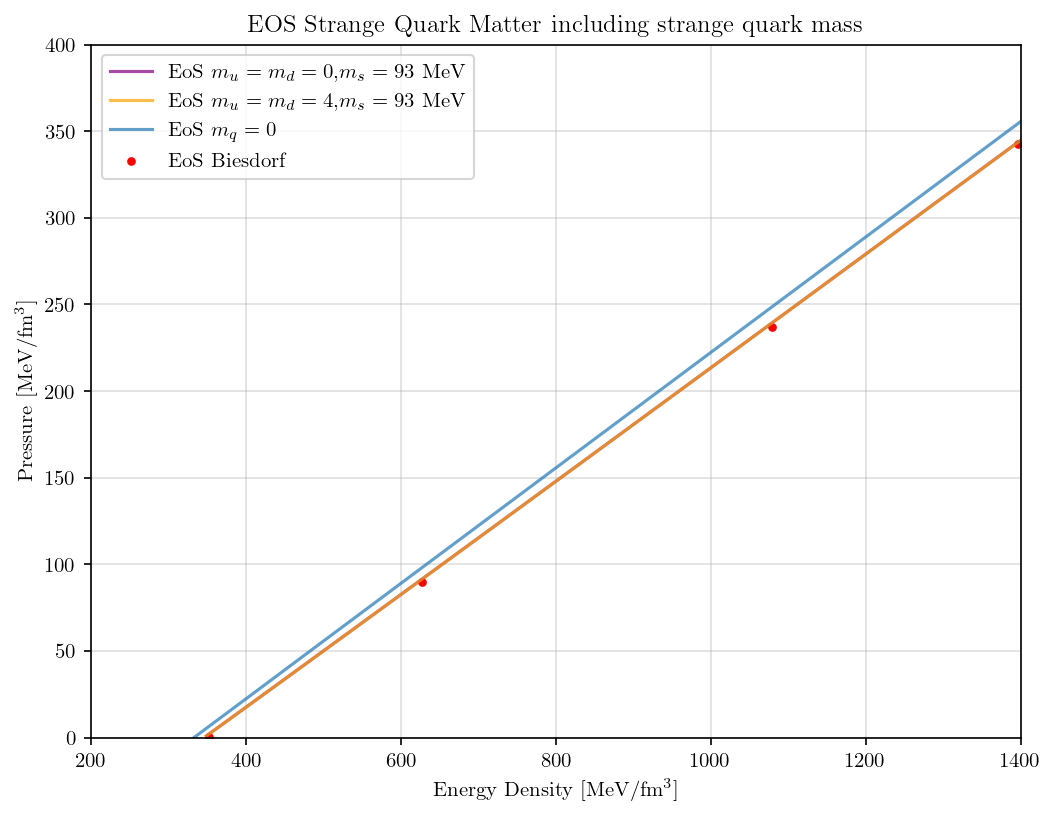

Number of points in EOS with positive pressure: 9964
Failed points (negative pressure): 36
Number of points in EOS with positive pressure: 9955
Failed points (negative pressure): 45


In [ ]:
n0  = n_0.value

hc = 197.327 
B = 159 ** 4 / hc**3 # in MeV/fm^3

N_c_quarks = 3
N_c_lep = 1

m_s = 93  # strange quark mass
m_u = 0
m_d = 0
m_e = 0

list_nbmax = np.linspace(0.1, 500, 10000) * n0
list_failed_nbmax = []
list_emax = []
list_pmax = []
for nB in list_nbmax:
    sol = fsolve(equationsNB, guess, args=(nB))
    mu_u, mu_e = sol    
    mu_d = mu_u + mu_e
    mu_s = mu_d
        
    nu = number_density_massless(mu_u)
    nd = number_density_massless(mu_d)
    ns = number_density_massive(mu_s, m_s)
    ne = number_density_electron(mu_e)

    check_nb = (1/3)*(nu + nd + ns) - nB
    check_charge = (2/3)*nu - (1/3)*nd - (1/3)*ns - ne

    if abs(check_nb) > 1e-6:
        print(f"Warning: nB check failed: {check_nb:.3e} fm^-3")

    if abs(check_charge) > 1e-6:
        print(f"Warning: charge neutrality check failed: {check_charge:.3e} fm^-3")


    pressure_total = (pressure_f(6, mu_u, m_u) + pressure_f(6, mu_d, m_d) +
                    pressure_f(6, mu_s, m_s) + pressure_f(2, mu_e, m_e)) - B
    
    if pressure_total < 0:
        #print('Negative pressure reached, stopping at nB=', nB)
        list_failed_nbmax.append(nB)
        continue


    energy_total =  (energy_f(6, mu_u, m_u) + energy_f(6, mu_d, m_d) +
                    energy_f(6, mu_s, m_s) + energy_f(2, mu_e, m_e)) + B

    z_s = m_s / mu_s 

    e = 3 * pressure_total + 4 * B + 6/(4* np.pi**2) * mu_s**4/hc**3 * z_s**(2)* ((1-z_s**2)**0.5 - z_s**2 * np.log((1 + (1 - z_s**2)**0.5)/z_s))
    check_e = energy_total - e
    
    if abs(check_e) > 1e-6:
        print(f"Warning: energy density check failed: {check_e:.3e} MeV/fm^3")
        print('for nB=', nB)

    list_emax.append(e)
    list_pmax.append(pressure_total)



plt.figure(figsize=(8,6), dpi=150)
#plt.scatter(np.array(list_e), np.array(list_p), color='purple',marker='x', alpha=0.4)
plt.plot(list_emax, list_pmax, 
        label='EoS $m_u = m_d = 0$,$m_s = 93$ MeV', color='purple', alpha=0.7)
plt.xlabel('Energy Density [MeV/fm$^3$]')
plt.ylabel('Pressure [MeV/fm$^3$]')
plt.title('EOS Strange Quark Matter including strange quark mass')
plt.grid()
plt.legend()




#-------------------------
m_s = 93  # strange quark mass
m_u = 4
m_d = 4
m_e = 0

list_nb2max = np.linspace(0.1, 500, 10000) * n0
list_failed_nb2max = []
list_e2max = []
list_p2max = []
for nB in list_nb2max:
    sol = fsolve(equationsNB2, guess, args=(nB))
    mu_u, mu_e = sol    
    mu_d = mu_u + mu_e
    mu_s = mu_d
        
    nu = number_density_massive(mu_u, m_u)
    nd = number_density_massive(mu_d, m_d)
    ns = number_density_massive(mu_s, m_s)
    ne = number_density_electron(mu_e)

    check_nb = (1/3)*(nu + nd + ns) - nB
    check_charge = (2/3)*nu - (1/3)*nd - (1/3)*ns - ne

    if abs(check_nb) > 1e-6:
        print(f"Warning: nB check failed: {check_nb:.3e} fm^-3")

    if abs(check_charge) > 1e-6:
        print(f"Warning: charge neutrality check failed: {check_charge:.3e} fm^-3")


    pressure_total = (pressure_f(6, mu_u, m_u) + pressure_f(6, mu_d, m_d) +
                    pressure_f(6, mu_s, m_s) + pressure_f(2, mu_e, m_e)) - B
    
    if pressure_total < 0:
        #print('Negative pressure reached, stopping at nB=', nB)
        list_failed_nb2max.append(nB)
        continue


    energy_total =  (energy_f(6, mu_u, m_u) + energy_f(6, mu_d, m_d) +
                    energy_f(6, mu_s, m_s) + energy_f(2, mu_e, m_e)) + B

    z_s = m_s / mu_s 


    list_e2max.append(energy_total)
    list_p2max.append(pressure_total)



plt.plot(list_e2max, list_p2max, 
        label='EoS $m_u = m_d = 4$,$m_s = 93$ MeV', color='orange', alpha=0.7)
plt.xlabel('Energy Density [MeV/fm$^3$]')
plt.ylabel('Pressure [MeV/fm$^3$]')
plt.title('EOS Strange Quark Matter including strange quark mass')
plt.grid()
plt.legend()



# ---- EOS -------
def P(e,B):
    return (e - 4 * B) / 3




#--------------------------------
#  MAXIMUM BAG CONSTANT
#--------------------------------

B_1_4 = 159 * u.MeV  
hc = 197.327 * u.MeV * u.fm

B_dim = B_1_4 ** 4 / hc**3
Bmax = B_dim / e_0
#--------------------------------

# ---- Plot my EOS ----

e = np.linspace(0 , 10, 1000)
p = P(e, Bmax)

plt.plot(e*e_0, p*e_0,
        label='EoS $m_q=0$', 
        linestyle='-', alpha=0.7)


# ---- Fit the data ----
data = pd.read_csv('../Data/eosBmax.csv')
plt.scatter(data['x'], data[' y'], color='red',s=10, label='EoS Biesdorf')
x = data['x'] / e_0
y = data[' y'] / e_0




plt.ylim(0, 400)
plt.xlim(200,1400)
plt.xlabel('Energy Density [MeV/fm$^3$]')
plt.ylabel('Pressure [MeV/fm$^3$]')
plt.legend()
plt.grid()

#plt.savefig('EOS_strange_quark_matter.png', dpi=300)
plt.show()

list_nbmax = list_nbmax[len(list_failed_nbmax):]
print("Number of points in EOS with positive pressure:", len(list_nb))
print("Failed points (negative pressure):", len(list_failed_nb))

list_nb2max = list_nb2max[len(list_failed_nb2max):]
print("Number of points in EOS with positive pressure:", len(list_nb2max))
print("Failed points (negative pressure):", len(list_failed_nb2max))


In [ ]:
goal_p = 500

e_interpolated = np.interp(goal_p, list_p, list_e)

print(f"Energy density at P={goal_p} MeV/fm^3: {e_interpolated:.2f} MeV/fm^3")

print(list_p[786], list_e[786])
print(list_p[787], list_e[787])

list_p_adim = np.array(list_p)/e_0.value
list_e_adim = np.array(list_e)/e_0.value


Energy density at P=500 MeV/fm^3: 1787.30 MeV/fm^3
3843.8695784822885 11884.93162595137
3850.204786676052 11904.023814648981


In [ ]:
def solve_TOV(central_energy, x0):
    def ode_TOV(r, x):
            p, M = x
            if p < 0:
                return [0, 0]
            
            e = np.interp(p, list_p_adim, list_e_adim)

            term1 = R_0 * e * M / r**2
            term2 = 1 + p / e
            if M == 0:
                term3 = 1.0
            else:
                term3 = 1.0 + alpha * r**3 * p / M
            term4 = 1 - 2 * R_0 * M / r

            if term4 <= 0:
                return [0, 0]

            dpdr = - term1 * term2 * term3 / term4
            dMdr = alpha * r**2 * e

            return [dpdr, dMdr]

    
    # ----------------------------------------------------
    # Solve ODE
    # ----------------------------------------------------

    # This solver automatically adjusts step size to control error
    sol = solve_ivp(
        ode_TOV,
        (r0, 100),     # integrate up to r=100 (large enough)
        x0,
        events=surface_event,
        max_step=0.1,
        rtol=1e-8, atol=1e-10 #tolerance error
    )

    if len(sol.t_events[0]) == 0:
        print(f"No surface event for central energy = {central_energy}")
        return np.nan, np.nan
    
    M_surface = sol.y_events[0][0][1]
    P_surface = sol.y_events[0][0][0]
    R_surface = sol.t_events[0][0]

    if P_surface > 1e-5 :
        print("Final pressure is far from 0:", P_surface* e_0, 'MeV/fm^3')
    
    return R_surface, M_surface




list_R = []
list_M = []

list_p_adim = np.array(list_p2)/e_0.value
list_e_adim = np.array(list_e2)/e_0.value

for i in range(len(list_nb2)):
    e, p = list_e2[i], list_p2[i]

    central_energy = e / e_0.value
    central_pressure = p / e_0.value

    r0 = 0.1            
    central_mass_density = (central_energy * e_0 / c**2 /M_sun).to(1/ u.km**3)
    central_mass = (4/3) * np.pi * r0**3 * central_mass_density.value
    x0 = [central_pressure, central_mass] 

    R_surface, M_surface = solve_TOV(central_energy, x0)


    list_R.append(R_surface)
    list_M.append(M_surface)




In [ ]:
list_p_adim = np.array(list_p2max)/e_0.value
list_e_adim = np.array(list_e2max)/e_0.value

list_Rmax = []
list_Mmax = []

for i in range(len(list_nb2max)):
    e, p = list_e2max[i], list_p2max[i]

    central_energy = e / e_0.value
    central_pressure = p / e_0.value

    r0 = 0.1            
    central_mass_density = (central_energy * e_0 / c**2 /M_sun).to(1/ u.km**3)
    central_mass = (4/3) * np.pi * r0**3 * central_mass_density.value
    x0 = [central_pressure, central_mass] 

    R_surface, M_surface = solve_TOV(central_energy, x0)


    list_Rmax.append(R_surface)
    list_Mmax.append(M_surface)



NameError: name 'list_p2max' is not defined

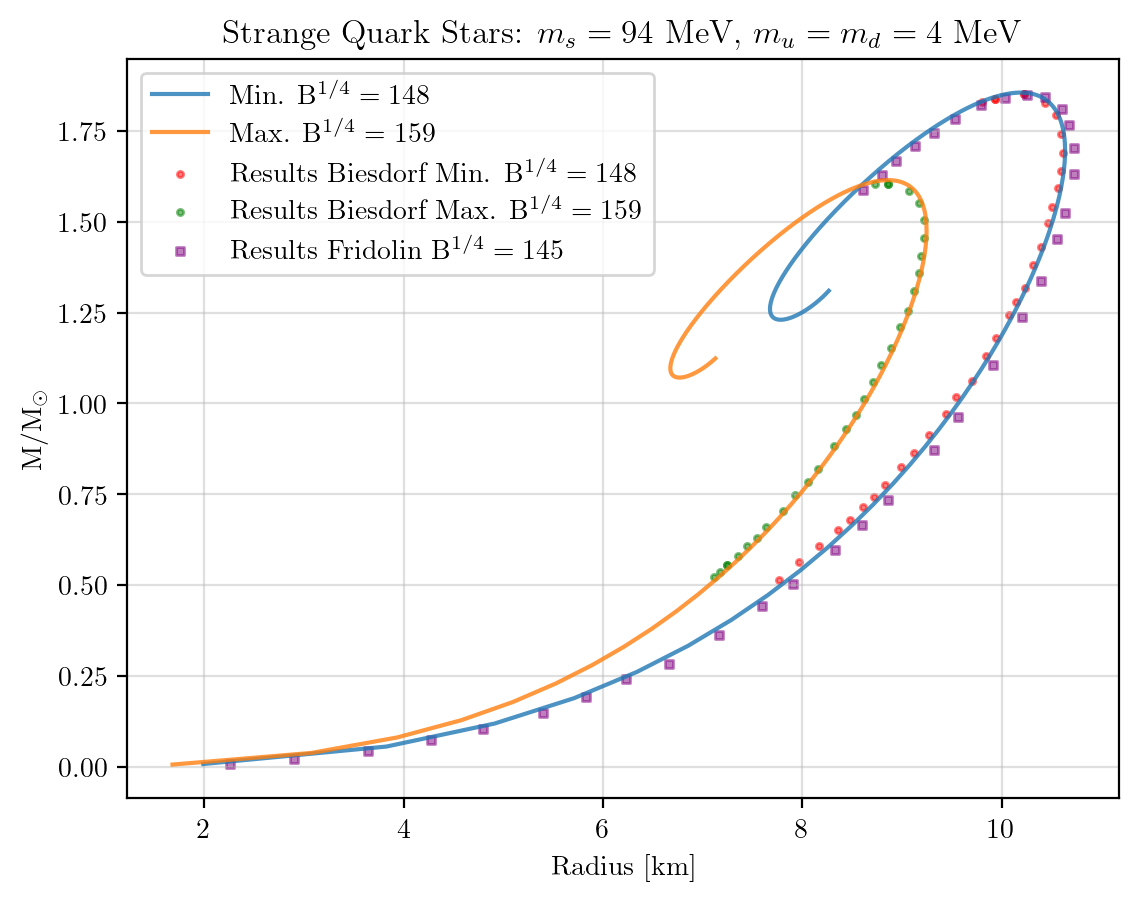

In [ ]:
plt.plot(list_R, list_M, label='Min. B$^{1/4} = 148$',alpha=0.8)
#plt.scatter(list_R, list_M, s=1)
plt.xlabel("Radius [km]")
plt.ylabel("M/M$_\odot$")
plt.title("Strange Quark Stars: $m_s=94$ MeV, $m_u=m_d=4$ MeV")

plt.plot(list_Rmax, list_Mmax, label='Max. B$^{1/4}=159$',alpha=0.8)
#plt.scatter(list_Rmax, list_Mmax, s=1)

data = pd.read_csv('../Data/Bmin_biesdorf.csv')
plt.scatter(data['x'], data[' y'], label='Results  Biesdorf Min. B$^{1/4}=148$', s=5, alpha=0.5, color = 'red')

data = pd.read_csv('../Data/Bmax_biesdorf.csv')
plt.scatter(data['x'], data[' y'], label='Results  Biesdorf Max. B$^{1/4}=159$', s=5, alpha=0.5,color='green')


data = pd.read_csv('../Data/fridolinMR.csv')
plt.scatter(data['x'], data[' y'], label='Results Fridolin B$^{1/4}=145$', color='purple', s=10, alpha=0.5, marker='s')


plt.grid()
plt.legend()

plt.savefig('Mass_Radius_strange_quark_matter_including_masses.png', dpi=300)
plt.show()

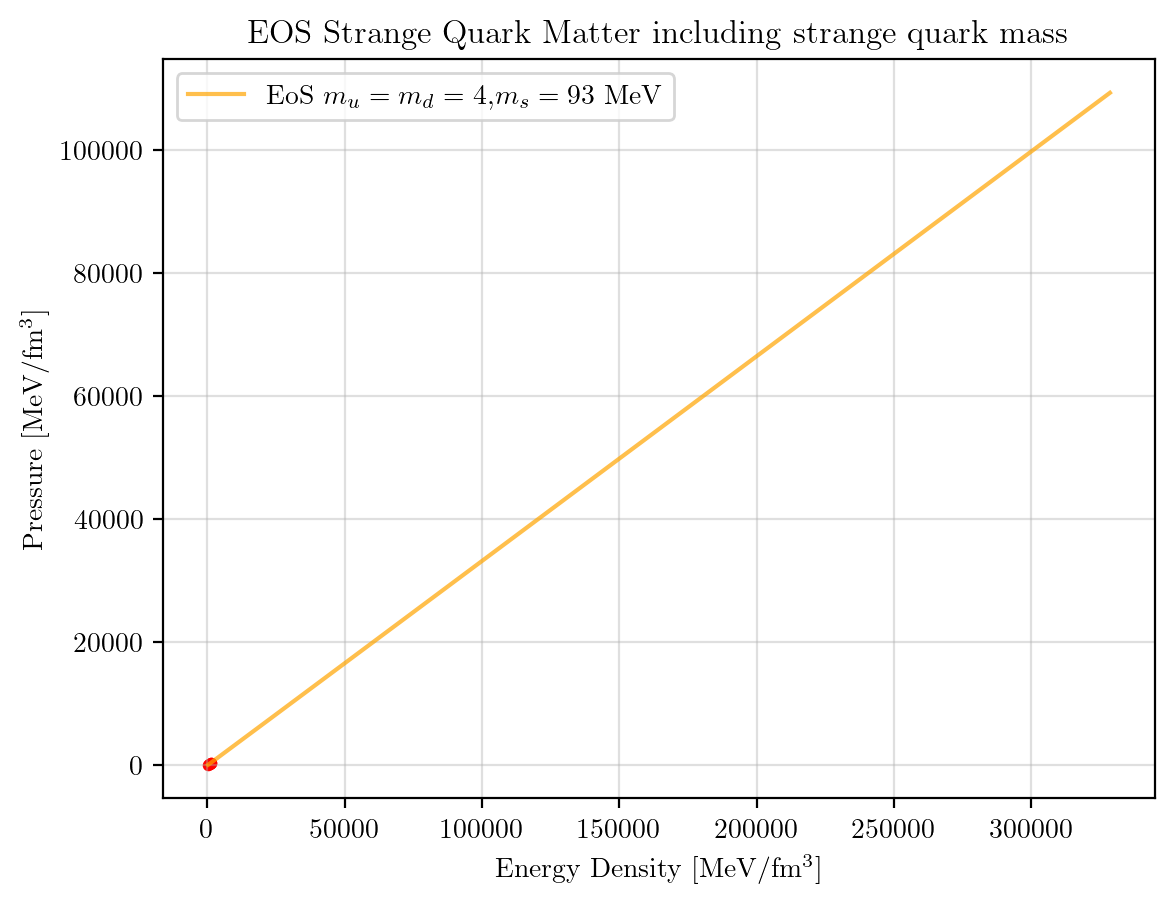

In [ ]:

plt.plot(list_e2, list_p2, 
        label='EoS $m_u = m_d = 4$,$m_s = 93$ MeV', color='orange', alpha=0.7)
plt.xlabel('Energy Density [MeV/fm$^3$]')
plt.ylabel('Pressure [MeV/fm$^3$]')
plt.title('EOS Strange Quark Matter including strange quark mass')
plt.grid()
plt.legend()

data = pd.read_csv('../Data/eosBmin.csv')
plt.scatter(data['x'], data[' y'], color='red',s=10, label='EoS Biesdorf')
x = data['x'] / e_0
y = data[' y'] / e_0


In [ ]:
#list e2 to g/cm^3
list_e2 = np.array(list_e2) * u.MeV / u.fm**3
list_e2 = list_e2 / c**2
list_e2 = list_e2.to(u.g / u.cm**3)




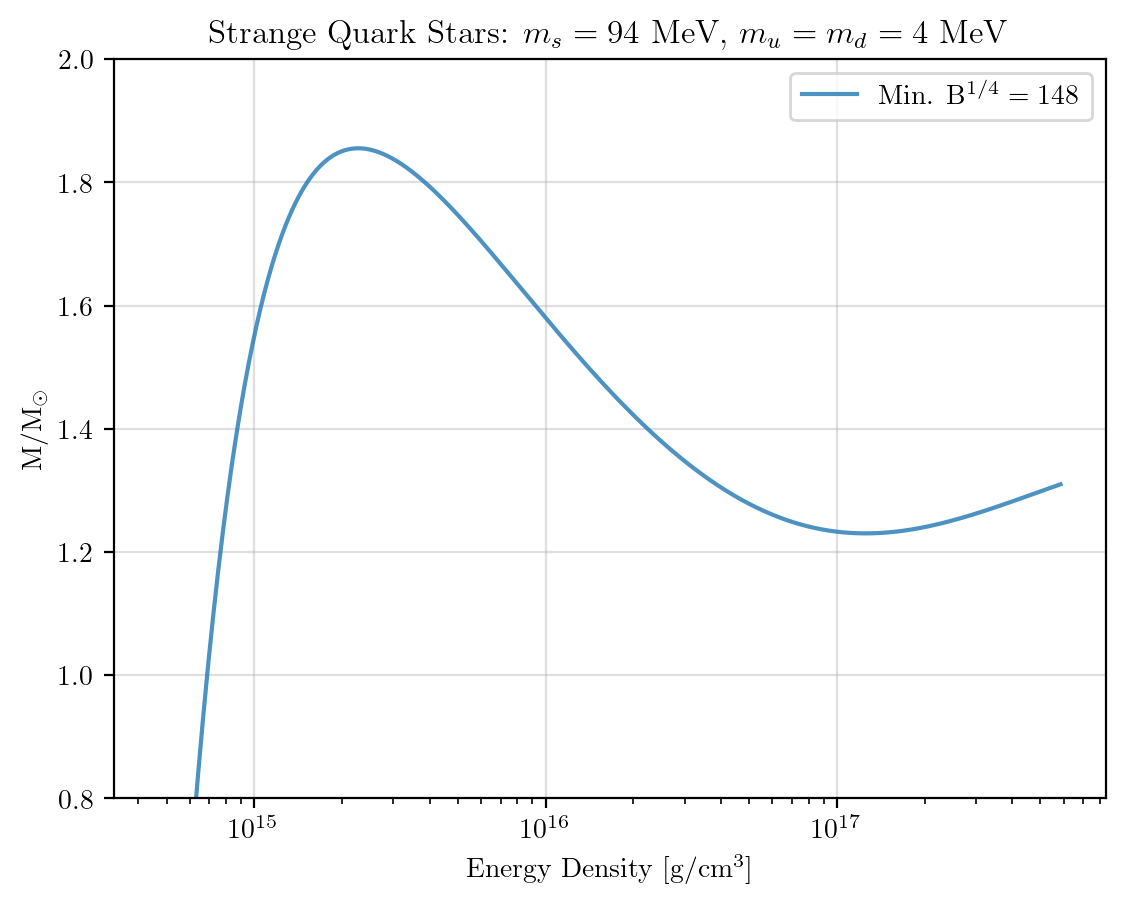

In [ ]:
plt.plot(list_e2, list_M, label='Min. B$^{1/4} = 148$',alpha=0.8)
plt.xlabel("Energy Density [g/cm$^3$]")
plt.ylabel("M/M$_\odot$")
plt.title("Strange Quark Stars: $m_s=94$ MeV, $m_u=m_d=4$ MeV")
plt.ylim(0.8,2)
plt.xscale('log')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# create a pandas dataframe with list_e list_e2

df = pd.DataFrame({'Energy Density massless (MeV/fm^3)': list_e,
                   'Pressure massless (MeV/fm^3)': list_p,
                   'Energy Density massive (MeV/fm^3)': list_e2,
                   'Pressure massive (MeV/fm^3)': list_p2,
                   'Energy difference (MeV/fm^3)': np.array(list_e2) - np.array(list_e),
                   'Pressure difference (MeV/fm^3)': np.array(list_p2) - np.array(list_p)})


,Energy Density massless (MeV/fm^3),Pressure massless (MeV/fm^3),Energy Density massive (MeV/fm^3),Pressure massive (MeV/fm^3),Energy difference (MeV/fm^3),Pressure difference (MeV/fm^3)
0,263.250427,0.776310,4.693334e+14,0.767108,4.693334e+14,-0.009202
1,270.227757,3.025518,4.817724e+14,3.016166,4.817724e+14,-0.009351
2,277.263019,5.294621,4.943147e+14,5.285121,4.943147e+14,-0.009500
3,284.355257,7.583283,5.069585e+14,7.573636,5.069585e+14,-0.009647
4,291.503554,9.891182,5.197023e+14,9.881390,5.197023e+14,-0.009792
...,...,...,...,...,...,...
9959,328458.837967,109215.192528,5.855329e+17,109214.841043,5.855329e+17,-0.351485
9960,328502.619233,109229.773654,5.856110e+17,109229.422146,5.856110e+17,-0.351508
9961,328546.401957,109244.355266,5.856890e+17,109244.003734,5.856890e+17,-0.351532
9962,328590.186139,109258.937364,5.857671e+17,109258.585809,5.857671e+17,-0.351555
